In [28]:
import os,json,math
import netCDF4 as nc4
import xarray,pandas,numpy
from osgeo import gdal, ogr, osr

import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap

datasets = json.load( open( "datasets.json" , "r" ) )

# Series

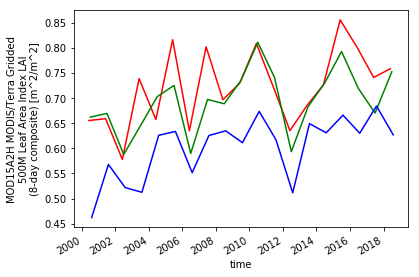

In [21]:
nc = xarray.open_dataset("outputs/compressed/mod15a2h_stats.nc",group="series")
mean = {l:g for l,g in nc['Lai_500m_mean'].groupby('time.month')}

mean[6].plot(color="red")
mean[7].plot(color="green")
mean[8].plot(color="blue")

# Grid

In [44]:
nc = xarray.open_dataset("outputs/compressed/mod15a2h_stats.nc",group="grid")
mean = {l:g for l,g in nc['Lai_500m_mean'].groupby('time.month')}

mean[6].sel(time=slice("2000")).plot(x='xdim',y='ydim',col='time',col_wrap=3)
#mean[7].plot(color="green")
#mean[8].plot(color="blue")



ValueError: IndexVariable objects must be 1-dimensional

## Transform to WGS84

In [19]:
nc = nc4.Dataset("outputs/compressed/mod15a2h_stats.nc", "r").groups['grid']

In [37]:
nc = nc4.Dataset("outputs/compressed/mod15a2h_stats.nc", "r").groups['grid']

bands = nc.variables['time'].size
ncols = nc.dimensions['xdim'].size
nrows = nc.dimensions['ydim'].size
xmax = max(nc.variables['xdim'][:])
xmin = min(nc.variables['xdim'][:])
ymax = max(nc.variables['ydim'][:])
ymin = min(nc.variables['ydim'][:])
xres = (xmax - xmin) / float(ncols)
yres = (ymax - ymin) / float(nrows)

print("".join(["SRS Metadata:\n",
    '\nbands:\t',str(bands),
    '\nncols:\t',str(ncols),
    '\nnrows:\t',str(nrows),
    '\nxmax:\t',str(xmax),
    '\nxmin:\t',str(xmin),
    '\nymax:\t',str(ymax),
    '\nymin:\t',str(ymin),
    '\nxres:\t',str(xres),
    '\nyres:\t',str(yres)
]))

SRS Metadata:

bands:	57
ncols:	8006
nrows:	5555
xmax:	-7337715.148008683
xmin:	-11046533.443813546
ymax:	5448789.202724933
ymin:	2875550.375129654
xres:	463.25484584122694
yres:	463.22931189834


In [31]:
#nc = xarray.open_dataset("outputs/compressed/mod15a2h_stats.nc",group="grid")
nc = nc4.Dataset("outputs/compressed/mod15a2h_stats.nc", "r").groups['grid']

bands = nc.variables['time'].size
ncols = nc.dimensions['xdim'].size
nrows = nc.dimensions['ydim'].size
xmax = max(nc.variables['xdim'][:])
xmin = min(nc.variables['xdim'][:])
ymax = max(nc.variables['ydim'][:])
ymin = min(nc.variables['ydim'][:])
xres = (xmax - xmin) / float(ncols)
yres = (ymax - ymin) / float(nrows)

datavar = 'Lai_500m_mean'
raster_wgs84 = "outputs/geotiffs/"+datavar+"_wgs84.tif"
raster_sinu = "outputs/geotiffs/"+datavar+"_sinu.tif"

sinu_proj4 = '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '
wgs84_proj4 = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs '

#####################################################################################

def nc_to_tif(nc,var,src_srs,dst_srs,src_tif,dst_tif):
    
    # get dates
    dates = nc4.num2date(nc.variables['time'][:], units=nc.variables['time'].units) # get dates from netcdf object
    
    # set input srs information
    source_srs = osr.SpatialReference() # get gdal proj4 reference object
    source_srs.ImportFromProj4(src_srs) # set srs object as sinusoidal proj4 string
    source_wkt = source_srs.ExportToWkt() # convert to wkt
    
    # get some metadata about shape of netCDF4 object
    bands = nc.variables['time'].size
    ncols = nc.dimensions['xdim'].size
    nrows = nc.dimensions['ydim'].size
    xmax = max(nc.variables['xdim'][:])
    xmin = min(nc.variables['xdim'][:])
    ymax = max(nc.variables['ydim'][:])
    ymin = min(nc.variables['ydim'][:])
    xres = (xmax - xmin) / float(ncols)
    yres = (ymax - ymin) / float(nrows)
    geotransform = (xmin, xres, 0, ymax, 0, -yres)                               # collect srs parameters
    
    print(src_tif)
    print(ncols)
    print(nrows)
    print(bands)
    print(gdal.GDT_Float32)
    dtype = gdal.GDT_Float32

    driver = gdal.GetDriverByName('GTiff')
    raster_sinu = driver.Create(src_tif,ncols,nrows,bands)#,dtype)      # make output raster object
    raster_sinu.SetGeoTransform(geotransform)                                    # set srs parameters
    raster_sinu.SetProjection(source_wkt)                                        # set srs
    for b in range(bands):
        print("Writing timestep "+str(b+1)+" / "+str(bands)+" to multiband geotiff ... ")
        array = np.ma.MaskedArray(nc.variables[datavar][b]).filled(255)          # get array from netCDF object
        raster_sinu.GetRasterBand(b+1).WriteArray(array)                         # write numpy array to band
        raster_sinu.GetRasterBand(b+1).SetNoDataValue(255)                       # set nodata
        raster_sinu.GetRasterBand(b+1).GetStatistics(0,1)                        # calculate band stats
        raster_sinu.GetRasterBand(b+1).SetDescription(dates[b].strftime('%Y'))   # set band descriptions
        raster_sinu.FlushCache()                                                 # write to disk

    # transform the grid
    gdal.Warp(dst_tif,raster_sinu,dstSRS=dst_srs)                                # warp to new raster object
    raster_wgs84 = gdal.Open(dst_tif, gdal.GA_Update)
    for b in range(bands):
        raster_wgs84.GetRasterBand(b + 1).GetStatistics(0,1)                     # calculate band stats
        raster_wgs84.GetRasterBand(b+1).SetDescription(dates[b].strftime('%Y'))  # set band descriptions
        raster_wgs84.FlushCache()                                                # write to disk

    # Close the files
    raster_sinu = None
    raster_wgs84 = None
    
# Run it
nc_to_tif(nc,datavar,sinu_proj4,wgs84_proj4,raster_sinu,raster_wgs84)

outputs/geotiffs/Lai_500m_mean_sinu.tif
8006
5555
57
6


TypeError: in method 'Driver_Create', argument 5 of type 'int'

# Scratch space

In [ ]:
import cartopy.crs as ccrs

nc = xarray.open_dataset("outputs/compressed/mod15a2h_stats.nc",group="grid")
mean = {l:g for l,g in nc['Lai_500m_mean'].groupby('time.month')}

#mean[6].plot(color="red")
#mean[7].plot(color="green")
#mean[8].plot(color="blue")

ax = plt.axes(projection=ccrs.Orthographic(-100, 35))

mean[6].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree());

ax.set_global(); ax.coastlines();

In [ ]:
tmp2 = nc['Lai_500m'].isel(time=0).load()

ncols,nrows = tmp2.xdim.size,tmp2.ydim.size    # get number of cols and rows
ymax,ymin = max(tmp2.ydim),min(tmp2.ydim)      # get max and min for y
xmax,xmin = max(tmp2.xdim),min(tmp2.xdim)      # get max and min for x
yres=(ymax-ymin)/float(nrows)              # get y res
xres=(xmax-xmin)/float(ncols)              # get x res
geotransform=(xmin,xres,0,ymax,0, -yres)   # define geotransformation

dst_ds = gdal.GetDriverByName('MEM').Create('', ncols, nrows, 1 ,gdal.GDT_Int16)   # open raster obj in memory
dst_rb = dst_ds.GetRasterBand(1)
dst_rb.Fill(255)                        # init with zeros
dst_rb.SetNoDataValue(255)              # set nodata value
dst_rb.WriteArray(tmp2.data)

dst_ds.SetGeoTransform(geotransform)    # set geotransform

dst_ds.FlushCache()

m = dst_ds.GetRasterBand(1).ReadAsArray()
m

data = dst_ds.ReadAsArray()
gt = dst_ds.GetGeoTransform()
proj = dst_ds.GetProjection()

xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * dst_ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * dst_ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5

#dst_ds = None

# create a grid of xy coordinates in the original projection
xy_source = numpy.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]

def convertXY(xy_source, inproj, outproj):
    # function to convert coordinates

    shape = xy_source[0,:,:].shape
    size = xy_source[0,:,:].size

    # the ct object takes and returns pairs of x,y, not 2d grids
    # so the the grid needs to be reshaped (flattened) and back.
    ct = osr.CoordinateTransformation(inproj, outproj)
    xy_target = numpy.array(ct.TransformPoints(xy_source.reshape(2, size).T))

    xx = xy_target[:,0].reshape(shape)
    yy = xy_target[:,1].reshape(shape)

    return xx, yy

# Create the figure and basemap object
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='ortho',lon_0=-105,lat_0=40,resolution='l')

# Create the projection objects for the convertion
inproj = osr.SpatialReference()
inproj.ImportFromProj4('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

im = m.pcolormesh(xx,yy,data[:,:],cmap=plt.cm.jet)
# annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)
# draw parallels and meridians.
#m.drawparallels(numpy.arange(-90.,120.,30.))
#m.drawmeridians(numpy.arange(0.,420.,60.))
#m.drawmapboundary(fill_color='aqua')
#plt.title("Full Disk Orthographic Projection")
plt.show()